In [1]:
# IMPORTS
import requests
import json
from sportmonks.soccer import SoccerApiV2
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, log_loss
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing
import xlsxwriter
import excel2json
from datetime import datetime
from sklearn.metrics import accuracy_score,confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus

//anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
//anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


In [2]:
# JSON FORMAT PRINT
def jprint(obj):
    # create a formatted string of the Python JSON object
    text = json.dumps(obj, sort_keys=True, indent=4)
    print(text)

In [3]:
# API key
soccer = SoccerApiV2(api_token='kDasthE00jpkFjEERAZNFyE9a79LNX3tPeaAqlhB3s2NhckJbKDhyL94j7AO')

In [4]:
# START AND END DATE 
start_date = "2018-08-10"
# end_date = "2018-08-19"
end_date = "2019-05-12"

# EMPTY LIST FOR ALL THE VARIABLES
lijst = []
sub_list = []
sub_list_min = []

# START QUERY
ids = soccer.fixtures(start_date, end_date, includes=('lineup', 'substitutions', 'venue', 'bench'))

# CHANGE THIS LIST TO THE FEATURES YOU APPED
inhoud = ['Name', 'Position', 'Minutes_played', 'Day_since_start', 'Total_minutes', 'Lineup_starts', 'Bench_starts', 'Venue', 'Injured'] 
lijst.append(inhoud)

# FOR LOOP TO GET ALL THE FIXTURES IN BETWEEN THE START AND END DATE
for f in ids:
    team = []
    index = 0
    
    # WHILE LOOP TO GET EVERY PLAYER OF THE LINEUP
    while len(team) < len(f['lineup']):
        speler = []
        minutes = 0
        
        # STANDARD FEATURES (name, position, minutes played, day since start date, injury)
        
        # NAME PLAYER
        name = f['lineup'][index]['player_name']        
        team.append(speler)
        
        # POSITION PLAYER
        position = f['lineup'][index]['position']        
        
        # MINUTES PLAYED
        minutes = f['lineup'][index]['stats']['other']['minutes_played']
        if minutes == None:
            continue                  
        
        # DAY SINCE START DATE
        current_date = f["time"]["starting_at"]["date"]
        date_format = "%Y-%m-%d"
        a = datetime.strptime(start_date, date_format)
        b = datetime.strptime(current_date, date_format)
        delta = b - a
        
        # TOTAL MINUTES PLAYED
        for iets in reversed(lijst):
            if iets[0] == name:
                gespeeld = iets[4]
                total = gespeeld + minutes
                break
            else:
                gespeeld = minutes
                total = gespeeld   
        
        # TIMES STARTED IN LINEUP 
        for iets in reversed(lijst):
            new_name = iets[0].split(' ')[-1]
            check_name = name.split(' ')[-1]
            if new_name == check_name and iets[0][0] == name[0]:
                nummer = iets[5]
                lineup_starts = nummer + 1
                break
            else:
                nummer = 0
                lineup_starts = nummer + 1
                
        # TIMES STARTED ON THE BENCH
        for iets in reversed(lijst):
            new_name = iets[0].split(' ')[-1]
            check_name = name.split(' ')[-1]
            if new_name == check_name and iets[0][0] == name[0]:
                nummer = iets[6]
                bench_starts = nummer
                break
            else:
                nummer = 0
                bench_starts = nummer
        
        # TARGET VALUE IF THE PLAYER IS INJURED
        injury_index = 0 
        injured = 'null'
        while injury_index < len(f['substitutions']):
            sub = []
            player_name = name.split(' ')
            sub_name = f['substitutions'][injury_index]['player_out_name']
            sub_name_split = sub_name.split(' ')  
            if player_name[-1] == sub_name_split[-1]:
                injured = f['substitutions'][injury_index]['injuried']
                break
            else:
                injury_index += 1
        
        # VARIABLE FEATURES 

        # VENUE SURFACE MATCH
        venue = f['venue']['surface']  
        
        # APPEND TO THE PLAYER'S LIST
        speler.append(name)
        speler.append(position)
        speler.append(minutes)
        speler.append(delta.days)
        speler.append(total)
        speler.append(lineup_starts)
        speler.append(bench_starts)
        speler.append(venue)
        if injured == True :
            speler.append('Yes')
        else:
            speler.append('No')
        
        # APPEND THE PLAYER TO THE BIG LIST
        lijst.append(speler)
        index += 1
        
    # SUBSTITUTES
    wissels = []
    index = 0
    
    # WHILE LOOP TO GET EVERY PLAYER OF BENCH
    while len(wissels) < len(f['bench']):
        speler = []
        minutes = 0
        
        # STANDARD FEATURES 
        
        # NAME PLAYER
        name = f['bench'][index]['player_name']        
        wissels.append(speler)
    
        # POSITION PLAYER
        position = f['bench'][index]['position']
        
        # MINUTES PLAYED
        minutes = f['bench'][index]['stats']['other']['minutes_played']
        if minutes == None:
            minutes = 0
        
        # DAY SINCE START DATE
        current_date = f["time"]["starting_at"]["date"]
        date_format = "%Y-%m-%d"
        a = datetime.strptime(start_date, date_format)
        b = datetime.strptime(current_date, date_format)
        delta = b - a
        
        # TOTAL MINUTES PLAYED
        for iets in reversed(lijst):
            if iets[0] == name:
                if iets[3] < delta.days: 
                    gespeeld = iets[4]
                    total = gespeeld + minutes
                    break
                else:
                    continue
            else:
                gespeeld = minutes
                total = gespeeld               
        
        # TIMES STARTED IN LINEUP 
        for iets in reversed(lijst):
            new_name = iets[0].split(' ')[-1]
            check_name = name.split(' ')[-1]
            if new_name == check_name and iets[0][0] == name[0]:
                nummer = iets[5]
                lineup_starts = nummer
                break
            else:
                nummer = 0
                lineup_starts = nummer
                
        # TIMES STARTED ON THE BENCH
        for iets in reversed(lijst):
            new_name = iets[0].split(' ')[-1]
            check_name = name.split(' ')[-1]
            if new_name == check_name and iets[0][0] == name[0]:
                nummer = iets[6]
                bench_starts = nummer + 1
                break
            else:
                nummer = 0
                bench_starts = nummer + 1
        
        # TARGET VALUE IF THE PLAYER IS INJURED
        
        # INJURY
        injury_index = 0 
        injured = 'null'
        while injury_index < len(f['substitutions']):
            sub = []
            player_name = name.split(' ')
            sub_name = f['substitutions'][injury_index]['player_out_name']
            sub_name_split = sub_name.split(' ')  
            if player_name[-1] == sub_name_split[-1]:
                injured = f['substitutions'][injury_index]['injuried']
                break
            else:
                injury_index += 1

        # VARIABLE FEATURES 
        
        # VENUE SURFACE MATCH
        venue = f['venue']['surface']         
        
        # APPEND TO THE PLAYER'S LIST
        speler.append(name)
        speler.append(position)
        speler.append(minutes)
        speler.append(delta.days)
        speler.append(total)
        speler.append(lineup_starts)
        speler.append(bench_starts)
        speler.append(venue)
        if injured == True :
            speler.append('Yes')
        else:
            speler.append('No')
        
        # APPEND THE PLAYER TO THE BIG LIST
        lijst.append(speler)
        index += 1


print(lijst)

[['Name', 'Position', 'Minutes_played', 'Day_since_start', 'Total_minutes', 'Lineup_starts', 'Bench_starts', 'Venue', 'Injured'], ['Diederik Boer', 'G', 90, 0, 90, 1, 0, 'artificial turf', 'No'], ['Kingsley Ehizibue', 'D', 90, 0, 90, 1, 0, 'artificial turf', 'No'], ['Darryl Lachman', 'D', 90, 0, 90, 1, 0, 'artificial turf', 'No'], ['Dirk Marcellis', 'D', 90, 0, 90, 1, 0, 'artificial turf', 'No'], ['Bram Van Polen', 'D', 90, 0, 90, 1, 0, 'artificial turf', 'No'], ['Gustavo Hamer', 'M', 90, 0, 90, 1, 0, 'artificial turf', 'No'], ['Clint Leemans', 'M', 90, 0, 90, 1, 0, 'artificial turf', 'No'], ['Denis Genreau', 'M', 46, 0, 46, 1, 0, 'artificial turf', 'No'], ['Zian Flemming', 'M', 87, 0, 87, 1, 0, 'artificial turf', 'No'], ['Vito van Crooy', 'A', 90, 0, 90, 1, 0, 'artificial turf', 'No'], ['Mike van Duinen', 'A', 90, 0, 90, 1, 0, 'artificial turf', 'No'], ['Warner Hahn', 'G', 90, 0, 90, 1, 0, 'artificial turf', 'No'], ['Doke Schmidt', 'D', 90, 0, 90, 1, 0, 'artificial turf', 'No'], ['Dan

In [5]:
# CODE TO EXPORT TO EXCEL 
with xlsxwriter.Workbook('ajaxsurface.xlsx') as workbook:
    worksheet = workbook.add_worksheet()

    for row_num, data in enumerate(lijst):
        worksheet.write_row(row_num, 0, data)

# CODE TO CONVERT EXCEL FILE TO JSON --> (Sheet1.json)
excel2json.convert_from_file('ajaxsurface.xlsx')


In [6]:
# READ THE JOSN FILE AND PRINT HEAD
ajax = pd.read_json("Sheet1.json")
print(ajax)

                    Name Position  Minutes_played  Day_since_start  \
0          Diederik Boer        G              90                0   
1      Kingsley Ehizibue        D              90                0   
2         Darryl Lachman        D              90                0   
3         Dirk Marcellis        D              90                0   
4         Bram Van Polen        D              90                0   
...                  ...      ...             ...              ...   
12106       Clint Essers        D               0              275   
12107      Andrija Balić        M              34              275   
12108    Lisandro Semedo        A              26              275   
12109          Agim Zeka        A              14              275   
12110    Lazaros Lamprou        A               0              275   

       Total_minutes  Lineup_starts  Bench_starts            Venue Injured  
0                 90              1             0  artificial turf      No  
1    

In [7]:
X = ajax.drop('Injured', axis = 1)
Y = pd.factorize(ajax.Injured)[0].reshape(-1, 1)

enc = preprocessing.OneHotEncoder()

enc.fit(X)
onehotlabels_x = enc.transform(X).toarray()

column_names = enc.get_feature_names(['Name', 'Position', 'Minutes_played', 'Day_since_start', 'Total_minutes', 'Lineup_starts', 'Bench_starts', 'Venue'])

enc.fit(Y)
onehotlabels_y = enc.transform(Y).toarray()

In [8]:
X_train, X_test, y_train, y_test = train_test_split(onehotlabels_x, onehotlabels_y, test_size=0.2)
X_train_val, X_val, y_train_val, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [9]:
classifier = DecisionTreeClassifier(random_state=0, max_depth=None)
classifier.fit(X_train_val, y_train_val)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [64]:
# from sklearn.naive_bayes import GaussianNB
# classifier = GaussianNB()
# classifier.fit(X_train_val, y_train_val)

In [10]:
# PREDICT VALIDATION
y_pred = classifier.predict(X_val)

In [11]:
# PRINT ACCURACY SCORE
print(accuracy_score(y_val, y_pred))

0.9938080495356038


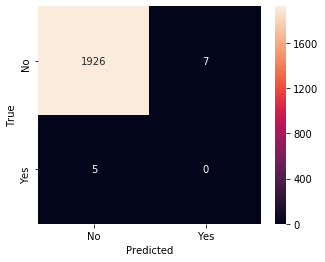

In [14]:
# PRINT CONFUSION MATRIX
features = ajax['Injured'].unique()

y_val_non_category = [ np.argmax(t) for t in y_val ]
y_valpredict_non_category = [ np.argmax(t) for t in y_pred ]

confusion_val = pd.DataFrame(confusion_matrix(y_val_non_category, y_valpredict_non_category),columns=features,index=features)
plt.figure(figsize=(5,4))
sns.heatmap(confusion_val, annot=True,fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [15]:
# PREDICT TEST 
y_pred = classifier.predict(X_test)

In [16]:
# PRINT ACCURACY SCORE
print(accuracy_score(y_test, y_pred))

0.9900949236483698


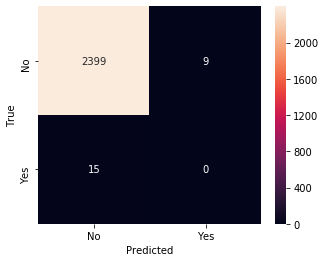

In [17]:
# PRINT CONFUSION MATRIX
features = ajax['Injured'].unique()

y_test_non_category = [ np.argmax(t) for t in y_test ]
y_predict_non_category = [ np.argmax(t) for t in y_pred ]

confusion_test = pd.DataFrame(confusion_matrix(y_test_non_category,y_predict_non_category),columns=features,index=features)
plt.figure(figsize=(5,4))
sns.heatmap(confusion_test,annot=True,fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [18]:
# feature_cols = ['Name', 'Position', 'Minutes_played', 'Day_since_start', 'Total_minutes', 'Lineup_starts', 'Bench_starts', 'Venue'] 

# dot_data = StringIO()
# export_graphviz(classifier, out_file=dot_data,  
#                 filled=True, rounded=True,
#                 special_characters=True, feature_names = feature_cols, class_names=['No','Yes'])
# graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
# graph.write_png('predictions.png')
# Image(graph.create_png())

In [21]:
spelers = lijst[1:]
arti_yes = 0
arti_no = 0
grass_yes = 0
grass_no = 0
for element in spelers:
    if element[7] == 'artificial turf' and element[8] == 'Yes':
        arti_yes += 1
    elif element[7] == 'artificial turf' and element[8] == 'No':
        arti_no += 1
    elif element[7] == 'grass' and element[8] == 'Yes':
        grass_yes += 1
    elif element[7] == 'grass' and element[8] == 'No':
        grass_no += 1
    else:
        print('hier gaat iets mis')
        
print('artificial yes:', arti_yes)
print('artificial no:', arti_no)

print('grass yes:', grass_yes)
print('grass no:', grass_no)


artificial yes: 19
artificial no: 3337
grass yes: 55
grass no: 8700


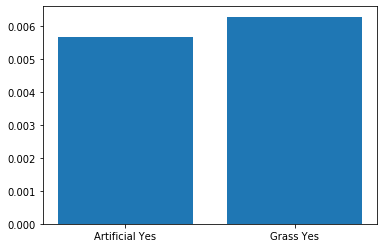

In [24]:
bars = ('Artificial Yes', 'Grass Yes')

per_arti_yes = arti_yes / (arti_yes + arti_no)
per_grass_yes = grass_yes / (grass_yes + grass_no)

height = [per_arti_yes, per_grass_yes]
y_pos = np.arange(len(bars))
 
# Create bars
plt.bar(y_pos, height)
 
# Create names on the x-axis
plt.xticks(y_pos, bars)
 
# Show graphic
plt.show()

In [67]:
# start_date = "2018-08-10"
# end_date = "2018-08-10"

# lijst = []
# sub_list = []
# sub_list_min = []

# # START QUERY
# wissels = soccer.fixtures(start_date, end_date, includes=('lineup', 'substitutions', 'venue', 'bench'))

# # CHANGE THIS LIST TO THE FEATURES YOU APPED
# inhoud = ['Name', 'Position', 'Minutes_played', 'Day_since_start', 'Total_minutes', 'Start_lineup', 'Venue', 'Injured'] 
# # inhoud = ['Position', 'Minutes_played', 'Day_since_start', 'Venue', 'Injured'] 
# lijst.append(inhoud)


# for f in wissels:
#     team = []
#     index = 0
    
#     # WHILE LOOP TO GET EVERY PLAYER OF THE LINEUP
#     while len(team) < len(f['substitutions']):
#         speler = []
#         minutes = 0
        
#         # STANDARD FEATURES (name, position, minutes played, day since start date, injury)
        
#         # NAME PLAYER
#         name = f['bench'][index]['player_name']        
#         speler.append(name)
#         team.append(speler)
    
#         # POSITION PLAYER
#         position = f['bench'][index]['position']
#         speler.append(position)
        
#         # MINUTES PLAYED
#         minutes = f['bench'][index]['stats']['other']['minutes_played']
#         if minutes == None:
#             minutes = 0
#         speler.append(minutes)
        
#         # DAY SINCE START DATE
#         current_date = f["time"]["starting_at"]["date"]
#         date_format = "%Y-%m-%d"
#         a = datetime.strptime(start_date, date_format)
#         b = datetime.strptime(current_date, date_format)
#         delta = b - a
#         speler.append(delta.days)
        
#         #TOTAL PLAYED
        
#         for iets in reversed(lijst):
#             if iets[0] == name:
#                 gespeeld = iets[4]
#                 total = gespeeld + minutes
#                 break
#             else:
#                 gespeeld = minutes
#                 total = gespeeld
#         counter = 1
#         for iets in reversed(lijst):
#             if iets[0] == name:
#                 counter += 1
#         speler.append(total)
#         speler.append(counter)
        
        
#         # VARIABLE FEATURES 
        
#         # VENUE SURFACE MATCH
#         venue = f['venue']['surface']
#         speler.append(venue)
        
        
        
#         # TARGET VALUE IF THE PLAYER IS INJURED
        
#         # INJURY
#         injury_index = 0 
#         injured = 'null'
#         while injury_index < len(f['substitutions']):
#             sub = []
#             player_name = name.split(' ')
#             sub_name = f['substitutions'][injury_index]['player_out_name']
#             sub_name_split = sub_name.split(' ')  
#             if player_name[-1] == sub_name_split[-1]:
#                 injured = f['substitutions'][injury_index]['injuried']
#                 break
#             else:
#                 injury_index += 1
#         if injured == True :
#             speler.append('Yes')
#         else:
#             speler.append('No')
        
#         # APPEND THE PLAYER TO THE BIG LIST
#         lijst.append(speler)
#         index += 1


# print(lijst)

In [ ]:
# start_date = "2018-08-10"
# end_date = "2018-08-10"

# # START QUERY
# wissels = soccer.fixtures(start_date, end_date, includes=('lineup', 'substitutions', 'bench'))

# for f in wissels:
#     jprint(f['bench'])